<a href="https://colab.research.google.com/github/VartanyanAdik/ML/blob/main/%D0%9E%D1%82%D1%82%D0%BE%D0%BA_%D0%BA%D0%BB%D0%B8%D0%B5%D0%BD%D1%82%D0%BE%D0%B2_%D0%B1%D0%B0%D0%BD%D0%BA%D0%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ПРЕДСКАЗАНИЕ ОТТОКА КЛИЕНТОВ БАНКА

> Add blockquote:




In [ ]:
! pip install -q kaggle

# Описание набора данных





Строки представляют клиентов, колонки - атрибуты клиентов.


Расшифровка каждого атрибута:
*   RowNumber — номер строки

*   CustomerId — уникальный номер клиента

*   Surname — фамилия клиента

*   CreditScore — кредитный рейтинг

*   Geography — страна клиента

*   Gender — пол клиента

*   Age — возраст пользователя

*   Tenure — количество лет, проведенных клиентом с банком

*   Balance — баланс на счете пользователя

*   HasCrCard — имеет ли клиент кредитную карту

*   NumOfProducts — количество продуктов, которые клиент приобрел в банке

*   IsActiveMember — активный клиент

*   EstimatedSalary — размер зарплаты

*   Exited — покинул клиент банк




# Загрузка данных


Подключение необходимых библиотек и функций


In [ ]:
import sklearn as sk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

Обзор датасета

In [ ]:
df = pd.read_csv('/kaggle/input/bank-customer-churn/Customer-Churn-Records.csv', sep = ',')


FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/bank-customer-churn/Customer-Churn-Records.csv'

In [ ]:
df.shape

(10000, 14)

In [ ]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


# Предварительная обработка данных


Общая информация



In [ ]:
df.info() #пустых столбцов не обнаружено. Имеются как числовые переменные, так и категориальные

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [ ]:
df.nunique()

,0
RowNumber,10000
CustomerId,10000
Surname,2932
CreditScore,460
Geography,3
Gender,2
Age,70
Tenure,11
Balance,6382
NumOfProducts,4


Чистка данных

In [ ]:
# Удалим столбцы CustomerId,RowNumber,Surname так, как они не требуются для обучения модели.
df = df.drop(['CustomerId', 'RowNumber', 'Surname'], axis=1)

In [ ]:
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [ ]:
#Разделим по типам признаков(количественные и качественные)
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
categorical = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember']#Exited как целевой признак будет отдельно

#Преобразуем признаки Balance и EstimatedSalary из float в int
df['Balance' ] = df['Balance'].astype(int)
df['EstimatedSalary' ] = df['EstimatedSalary'].astype(int)

#Преобразование с помощью LabelEncoder
le = LabelEncoder()
df[['Geography', 'Gender']] = df[['Geography', 'Gender']].apply(lambda col: le.fit_transform(col))




# Визуализация ключевого признака

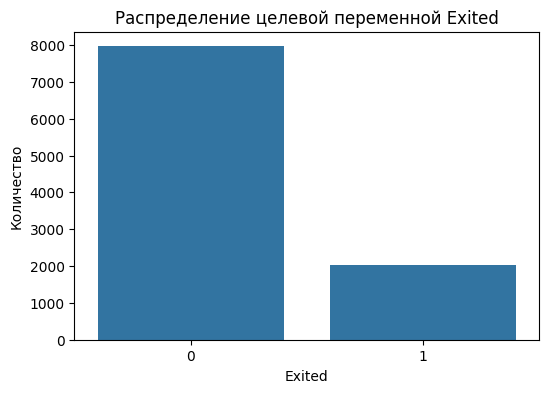

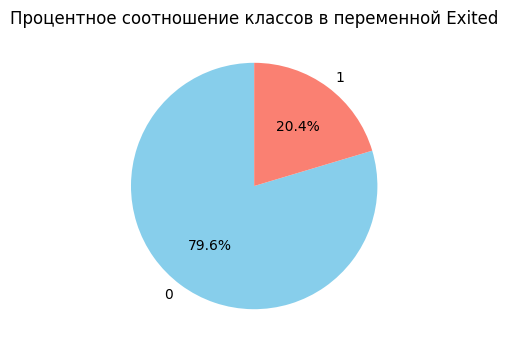

In [ ]:
# Построим гистограммы для определения баланса классов.
plt.figure(figsize=(6, 4))
sns.countplot(x='Exited', data=df)
plt.title('Распределение целевой переменной Exited')
plt.xlabel('Exited')
plt.ylabel('Количество')
plt.show()

plt.figure(figsize=(6, 4))
df['Exited'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, colors=['skyblue', 'salmon'])
plt.title('Процентное соотношение классов в переменной Exited')
plt.ylabel('')
plt.show()


In [ ]:
#Сделаем визуализацию корреляции
corr = df.corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Корреляционная матрица')
plt.show()

NameError: name 'df' is not defined

Виден дисбаланс классов в соотношении 4 к 1

Сильнее всего с ключевой переменной кореллируют признаки Age, Balance

Видна сильная связь между признаками Balance и NumOfProducts




# Визуализация категориальных признаков

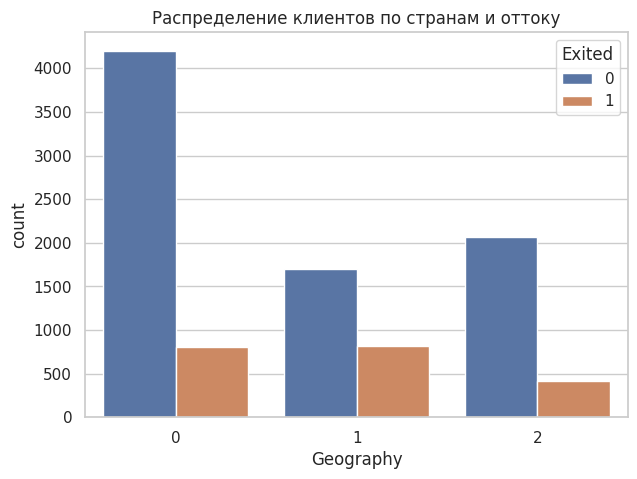

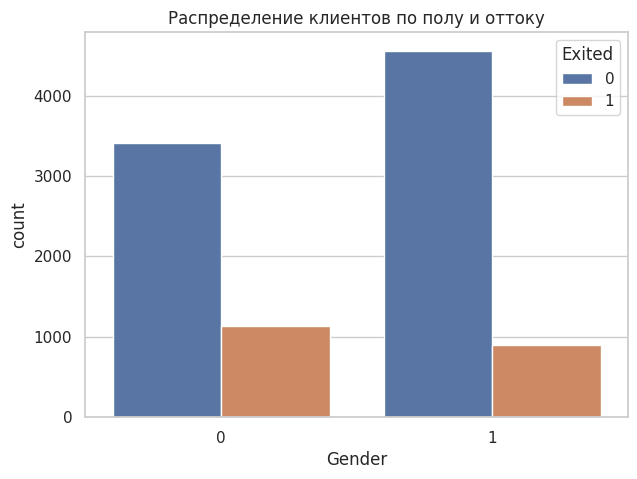

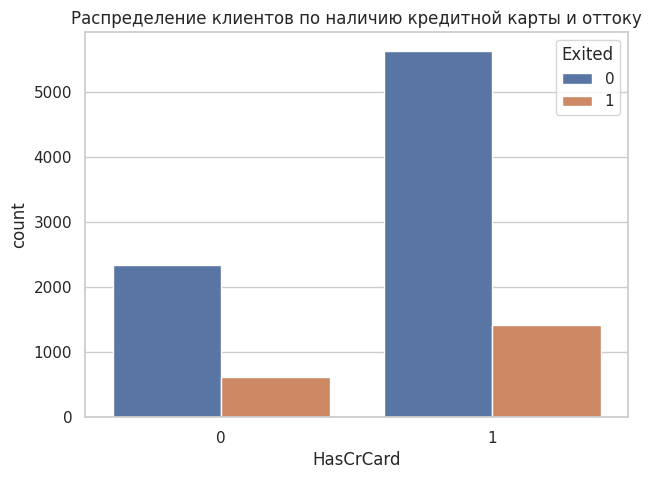

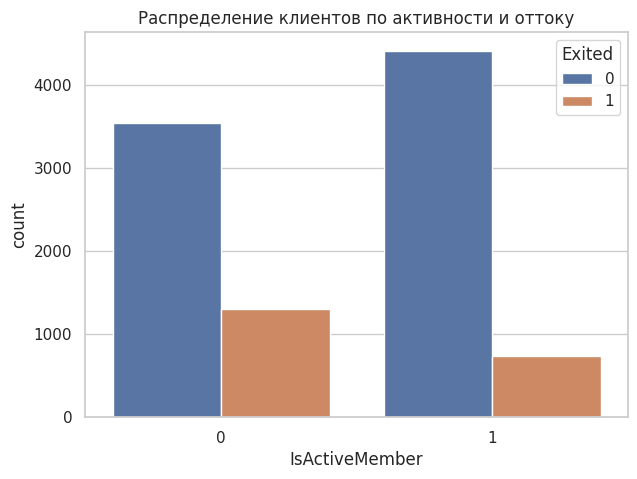

In [ ]:
# Настройка стиля визуализаций
sns.set(style="whitegrid")

# Визуализация признака Geography
plt.figure(figsize=(7, 5))
sns.countplot(x='Geography', hue='Exited', data=df)
plt.title('Распределение клиентов по странам и оттоку')
plt.show()

# Визуализация признака Gender
plt.figure(figsize=(7, 5))
sns.countplot(x='Gender', hue='Exited', data=df)
plt.title('Распределение клиентов по полу и оттоку')
plt.show()

# Визуализация признака HasCrCard
plt.figure(figsize=(7, 5))
sns.countplot(x='HasCrCard', hue='Exited', data=df)
plt.title('Распределение клиентов по наличию кредитной карты и оттоку')
plt.show()

# Визуализация признака IsActiveMember
plt.figure(figsize=(7, 5))
sns.countplot(x='IsActiveMember', hue='Exited', data=df)
plt.title('Распределение клиентов по активности и оттоку')
plt.show()

Из диаграмм видно, что женщины покидают банк чаще мужчин.

Также видна разница покинутых клиентов по странам.

Имеется понятная зависимость активности и оттока

# Визуализация количественных признаков

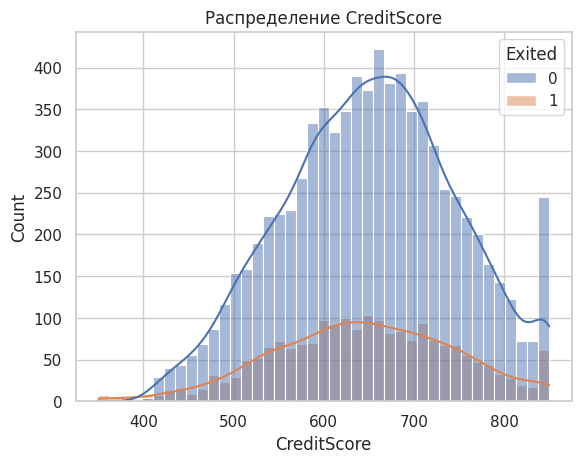

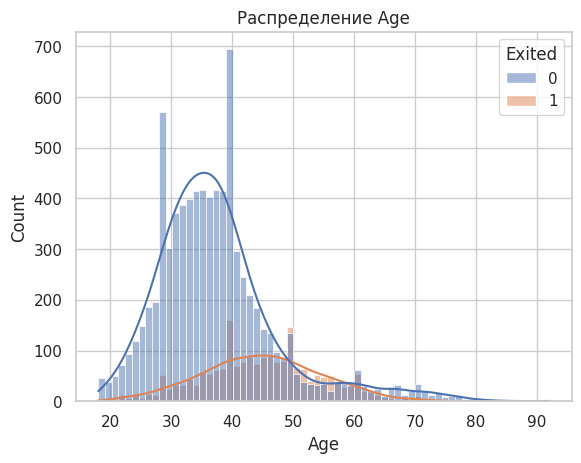

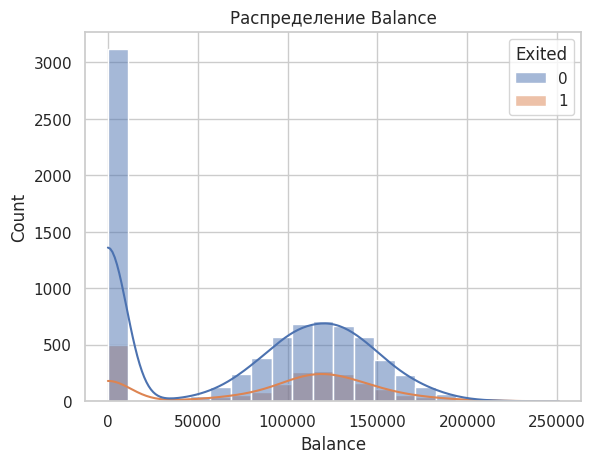

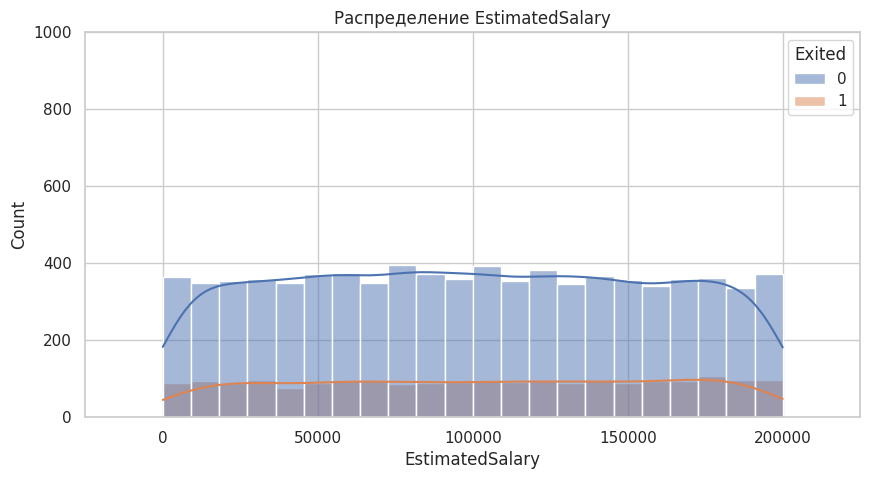

In [ ]:
# Распределение для CreditScore
sns.histplot(x='CreditScore', hue='Exited', data=df, kde=True)
plt.title('Распределение CreditScore')
plt.show()

# Распределение для Age
sns.histplot(x='Age', hue='Exited', data=df, kde=True)
plt.title('Распределение Age')
plt.show()

# Распределение для Balance
sns.histplot(x='Balance', hue='Exited', data=df, kde=True)
plt.title('Распределение Balance')
plt.show()

# Распределение для EstimatedSalary
plt.figure(figsize=(10, 5))
sns.histplot(x='EstimatedSalary', hue='Exited', data=df, kde=True)
plt.title('Распределение EstimatedSalary')
plt.xlim(-25000, 225000)
plt.ylim(0, 1000)
plt.show()

In [ ]:
df[['CreditScore', 'Age', 'Balance', 'EstimatedSalary']].describe()

,CreditScore,Age,Balance,EstimatedSalary
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,76485.571500,100089.748400
std,96.653299,10.487806,62397.185107,57510.491042
min,350.000000,18.000000,0.000000,11.000000
25%,584.000000,32.000000,0.000000,51001.750000
50%,652.000000,37.000000,97198.000000,100193.500000
75%,718.000000,44.000000,127643.750000,149387.750000
max,850.000000,92.000000,250898.000000,199992.000000


Выбросов не обнаружено

Видно значимое различие в распределениях возраста


# Моделирование

[[1559   48]
 [ 322   71]]
              precision    recall  f1-score   support

           0       0.83      0.97      0.89      1607
           1       0.60      0.18      0.28       393

    accuracy                           0.81      2000
   macro avg       0.71      0.58      0.59      2000
weighted avg       0.78      0.81      0.77      2000

ROC AUC: 0.58


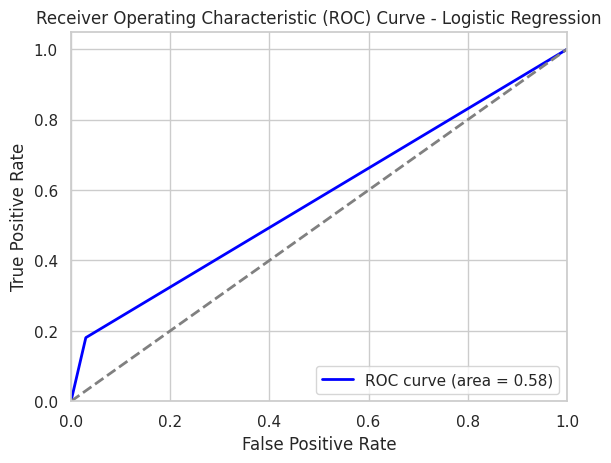

In [ ]:
# Разделяем данные на признаки (X) и целевую переменную (y)
X = df.drop('Exited', axis=1)
y = df['Exited']

# Разделяем данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Стандартизируем данные
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Создаем и обучаем модель логистической регрессии
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

# Делаем предсказания и оцениваем модель
y_pred = log_reg.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Рассчитываем и выводим ROC AUC
roc_auc = roc_auc_score(y_test, y_pred)
print(f'ROC AUC: {roc_auc:.2f}')

# Строим ROC кривую
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Logistic Regression')
plt.legend(loc='lower right')
plt.show()

[[1356  251]
 [ 187  206]]
              precision    recall  f1-score   support

           0       0.88      0.84      0.86      1607
           1       0.45      0.52      0.48       393

    accuracy                           0.78      2000
   macro avg       0.66      0.68      0.67      2000
weighted avg       0.79      0.78      0.79      2000

[[1356  251]
 [ 187  206]]
              precision    recall  f1-score   support

           0       0.88      0.84      0.86      1607
           1       0.45      0.52      0.48       393

    accuracy                           0.78      2000
   macro avg       0.66      0.68      0.67      2000
weighted avg       0.79      0.78      0.79      2000

ROC AUC: 0.68


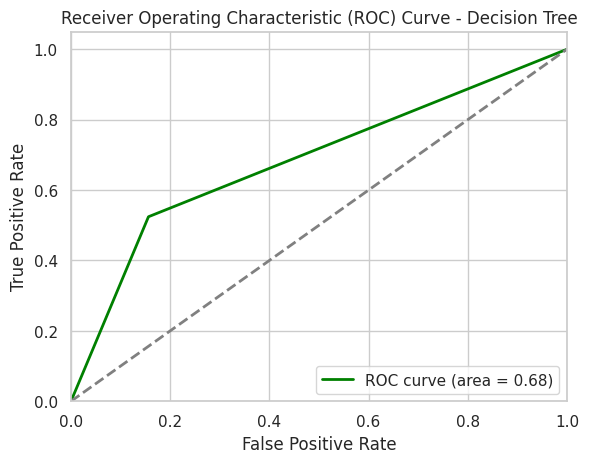

In [ ]:
# Создаем и обучаем модель дерева решений
tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train, y_train)

# Делаем предсказания и оцениваем модель
y_pred = tree.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Выводим матрицу ошибок и отчет классификации
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Рассчитываем и выводим ROC AUC
roc_auc = roc_auc_score(y_test, y_pred)
print(f'ROC AUC: {roc_auc:.2f}')

# Строим ROC кривую
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.figure()
plt.plot(fpr, tpr, color='green', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Decision Tree')
plt.legend(loc='lower right')
plt.show()

[[1545   62]
 [ 209  184]]
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1607
           1       0.75      0.47      0.58       393

    accuracy                           0.86      2000
   macro avg       0.81      0.71      0.75      2000
weighted avg       0.85      0.86      0.85      2000

ROC AUC: 0.71


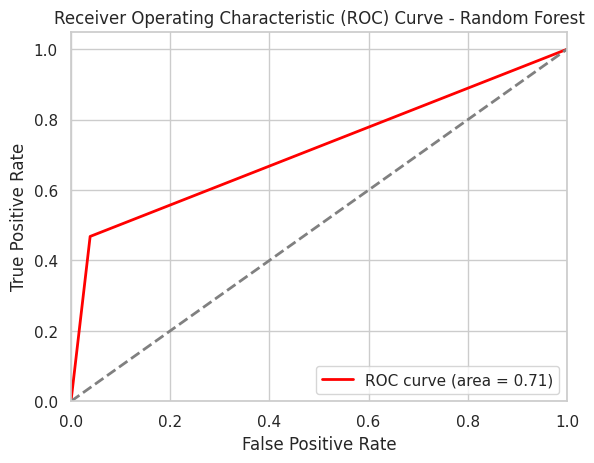

In [ ]:
# Создаем и обучаем модель случайного леса
forest = RandomForestClassifier(n_estimators=100, random_state=42)
forest.fit(X_train, y_train)

# Делаем предсказания и оцениваем модель
y_pred = forest.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Рассчитываем и выводим ROC AUC
roc_auc = roc_auc_score(y_test, y_pred)
print(f'ROC AUC: {roc_auc:.2f}')

# Строим ROC кривую
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.figure()
plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Random Forest')
plt.legend(loc='lower right')
plt.show()

[[1536   71]
 [ 201  192]]
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1607
           1       0.73      0.49      0.59       393

    accuracy                           0.86      2000
   macro avg       0.81      0.72      0.75      2000
weighted avg       0.85      0.86      0.85      2000

ROC AUC: 0.72


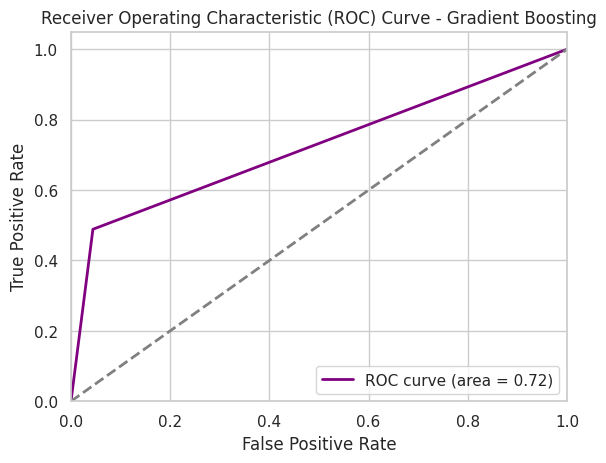

In [ ]:
# Создаем и обучаем модель градиентного бустинга
gb = GradientBoostingClassifier(n_estimators=200, random_state=42)
gb.fit(X_train, y_train)

# Делаем предсказания и оцениваем модель
y_pred = gb.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Рассчитываем и выводим ROC AUC
roc_auc = roc_auc_score(y_test, y_pred)
print(f'ROC AUC: {roc_auc:.2f}')

# Строим ROC кривую
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.figure()
plt.plot(fpr, tpr, color='purple', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Gradient Boosting')
plt.legend(loc='lower right')
plt.show()

[[1519   88]
 [ 241  152]]
              precision    recall  f1-score   support

           0       0.86      0.95      0.90      1607
           1       0.63      0.39      0.48       393

    accuracy                           0.84      2000
   macro avg       0.75      0.67      0.69      2000
weighted avg       0.82      0.84      0.82      2000

ROC AUC: 0.67


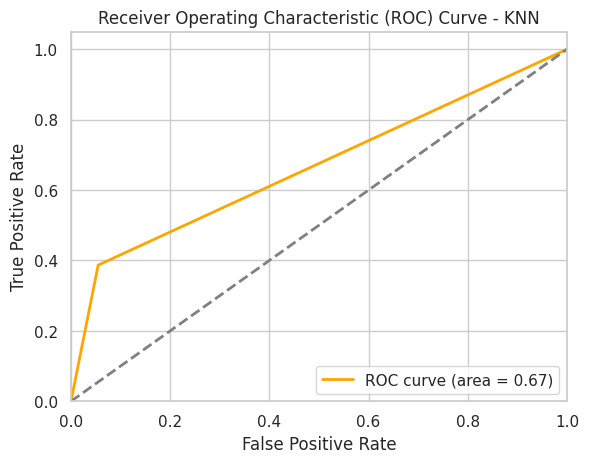

In [ ]:
# Создаем и обучаем модель K-ближайших соседей
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# Делаем предсказания и оцениваем модель
y_pred = knn.predict(X_test)
y_pred_proba = knn.predict_proba(X_test)[:, 1]

# Выводим матрицу ошибок и отчет классификации
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Рассчитываем и выводим ROC AUC
roc_auc = roc_auc_score(y_test, y_pred)
print(f'ROC AUC: {roc_auc:.2f}')

# Строим ROC кривую
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.figure()
plt.plot(fpr, tpr, color='orange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - KNN')
plt.legend(loc='lower right')
plt.show()

В ходе проведения работы данные были изучены, обработаны и использованы для обучения.

Модель градиентного бустинга оказался наиболее эффективным, также результат близкий к нему показала модель случайного леса. Наименее эффективным себя показала модель логистической регрессии.